# Building Explainable Machine Learning Models

## Permutation Feature Importance

* What features does a model think are important?
* Which features might have a greater impact on the model predictions than others? 

This concept is called **feature importance** and **Permutation Importance** is a technique used widely for calculating feature importance. 

<div class="alert alert-block alert-info">
    
* Permutation Importance sheds light on which features are most important to any machine learning algorithm. This technique was introduced by Bremen in his [Random Forests Paper](https://doi.org/10.1023/A:1010933404324) and based on this idea [Aaron Fisher, Cynthia Rudin, Francesca Dominici ](https://arxiv.org/abs/1801.01489) proposed model agnostic version of the feature importance which they called **Model Reliance**.
    
* Permutation importance is calculated after a model has been fitted. 
    
* Also make sure that the model has a good predictive performance or in other words you have trained a good model before inspecting the importance of its features. There is no point in investigating a bad model.
    
</div>


---

## Case Study: Diagnosing Heart Disease

We are given some diagnostic data of few patients.The objective of the dataset is to predict where the patient has a heart disease or not based on the other diagnostic measurements provided in the dataset.

<img src=https://cdn.pixabay.com/photo/2018/10/05/05/19/stethoscope-3725131_960_720.png alt="Heart" width="500" height="600">

## Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [2]:
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz # plot tree
from sklearn.metrics import roc_curve, auc # for model evaluation
from sklearn.metrics import classification_report # for model evaluation
from sklearn.metrics import confusion_matrix # for model evaluation
np.random.seed(123) # ensure reproducibility

import warnings  
warnings.filterwarnings("ignore")

In [3]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, rc={"figure.figsize":(12,8)})

##  Reading in the Dataset

The dataset used is called the **Heart disease data**  and is hosted at the UCI Machine Learning repository and available at this [link](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).The dataset used in this notebook belongs to the [Kaggle version and can be accessed here](https://www.kaggle.com/ronitf/heart-disease-uci). The objective of the dataset is to predict where the patient has a heart disease or not based on the other diagnostic measurements provided in the dataset.



> **Source**:
>
> Creators:
>
>1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
>2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
>3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
>4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.
>
> Donor:
>
>David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

Let’s read in the data and look at the first few rows

In [4]:
df = pd.read_csv('heart_disease.csv')
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

-   **age**: The person's age in years
-   **sex**: The person's sex (1 = male, 0 = female)
-   **cp:**  The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
-   **trestbps:**  The person's resting blood pressure (mm Hg on admission to the hospital)
-   **chol:**  The person's cholesterol measurement in mg/dl
-   **fbs:**  The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
-   **restecg:**  Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
-   **thalach:**  The person's maximum heart rate achieved
-   **exang:**  Exercise induced angina (1 = yes; 0 = no)
-   **oldpeak:**  ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more  [here](https://litfl.com/st-segment-ecg-library/))
-   **slope:**  the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
-   **ca:**  The number of major vessels (0-3)
-   **thal:**  A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
-   **target:**  Heart disease (0 = no, 1 = yes)




As can be seen, the dataset consists of various predictor variables like `age`, `sex`, `cholestrol`, etc, and one target variable, `target`. The `target` variable is `1` if the patient has a heart disease and `0` for no heart disease. It is a classic binary classification problem. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


There are no missing values and no string columns in the given dataset.

In [6]:
# Inspecting Distribution of Target Variable
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

## Data Preparation 

### Renaming Columns
Let's change the column names to be a bit clearer.

In [7]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
              'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 
              'thalassemia', 'target']

# Print first five rows of the data
df.head()

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                        0            2.3         0                  0   
1                        0            3.5         0                  0   
2                        0            1.4         2                  0   
3                        0            0.8         2                  0   
4                        1            0.6         2                  0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1

### Train/Test Split
Splitting the dataset into training and validation dataset.

In [8]:
# Creating the target and the features column and splitting the dataset into test and train set.
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]  
  
# splitting the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Training the classifier

Now you will fit a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 20 estimators and compute the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) achieved:

In [9]:
# Training and fitting a Random Forest Model
model_rf = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=0).fit(X_train, y_train)

# Making predictions on the test set
y_pred = model_rf.predict_proba(X_test)[:, 1]

# Print the AUC score achieved by the classifier on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.9189570119802678

We now have our model and our predictions. Let’s now explore the different ways by which we can understand the model and its predictions in a more meaningful way. 

---

## Calculating Permutation Feature Importance 

Permutation Importance works as follows: 
    
* Randomly permutate or shuffle one column in the validation dataset leaving all the other columns intact. 
* A feature is considered <mark>important</mark> if shuffling its values increases the model error because in this case, the model relied on the feature for the prediction.
* On the other hand, a feature is considered <mark>unimportant</mark> if shuffling its values leaves the model error unchanged because in this case, the model ignored the feature. If we find that we have unimportant features then we should really consider removing them from our feature vector.
* Finally the features are sorted in descending order based on the importance measure.

![](https://imgur.com/S6okz3f.png)

Source: [sklearn documentation on permutation Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

In [10]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_rf, 
                                X_test, 
                                y_test,
                                n_repeats=30,n_jobs=2,
                                random_state=0)

In [11]:
result.importances_mean.argsort()

array([ 3,  7,  6,  5,  8,  1, 10,  0,  4, 11,  9,  2, 12], dtype=int64)

## Visualizing the distributionsm

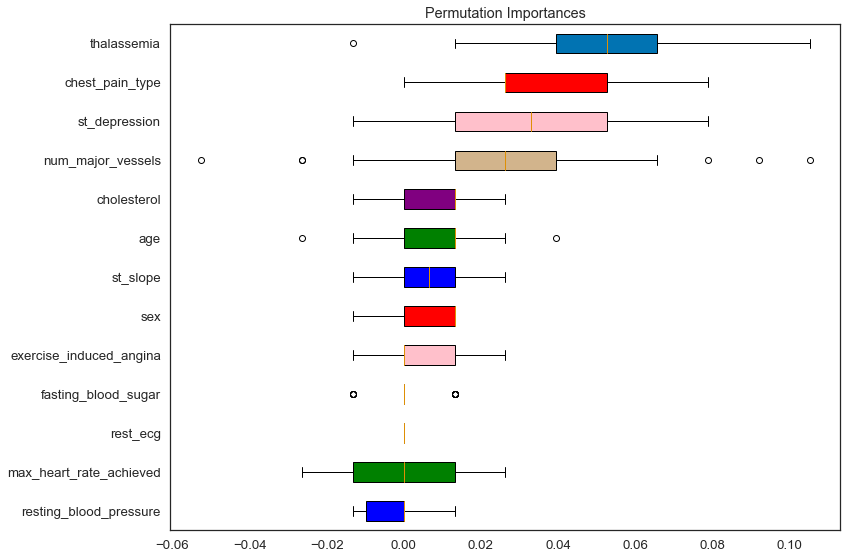

In [12]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
boxplot = ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx],patch_artist=True)

colors = ['blue', 'green', 'purple', 'tan', 'pink', 'red','blue', 'green', 'purple', 'tan', 'pink', 'red']
for patch, color in zip(boxplot['boxes'], colors): 
    patch.set_facecolor(color) 

ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

## Interpretation
-   The features at the top are most important and at the bottom, the least. 
-   The whiskers measures how performance varied from one-reshuffling to the next.
-   Some weights are negative. This is because, in those cases, predictions on the shuffled data were found to be more accurate than the real data.

---

## Advantages 
    
* Model Agnostic
* Gives a global overview
* Easy to interpret
* Doesn’t require model retraining


## Drawbacks
    
* Not clear consensus on whether Test or Training Data should be used.
* Correlated features are a problem.
* Need access to labelled data
* computationally expensive for large datasets